## Dogs v Cats super-charged!

In [1]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = "data/dogs-cats-redux/"
sz=299
arch=resnext50
bs=20

In [3]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=4, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)

In [4]:
learn.fit(1e-2, 1)
learn.precompute=False

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                        
    0      0.0624     0.021892   0.9936    



In [5]:
learn.fit(1e-2, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      0.031053   0.018507   0.9936    
    1      0.035184   0.01695    0.9952                         



[0.01695004, 0.9951999988555909]

In [6]:
learn.unfreeze()
lr=np.array([1e-4,1e-3,1e-2])

In [7]:
learn.fit(lr, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                       
    0      0.052709   0.01848    0.994     
    1      0.042307   0.016757   0.9952                         
    2      0.019232   0.015151   0.9952                         



[0.015151059, 0.9951999988555909]

In [8]:
learn.save('224_all_50')

In [9]:
learn.load('224_all_50')

In [10]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y)

0.9956

In [11]:
metrics.log_loss(y,probs)

0.016298921632486668

## Analyzing results

In [12]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[1278    8]
 [   3 1211]]


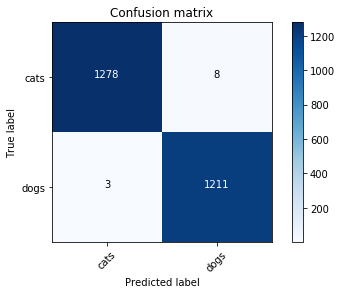

In [13]:
plot_confusion_matrix(cm, data.classes)

In [18]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask((preds == data.val_y)==is_correct & (data.val_y == y), mult)

Most incorrect cats


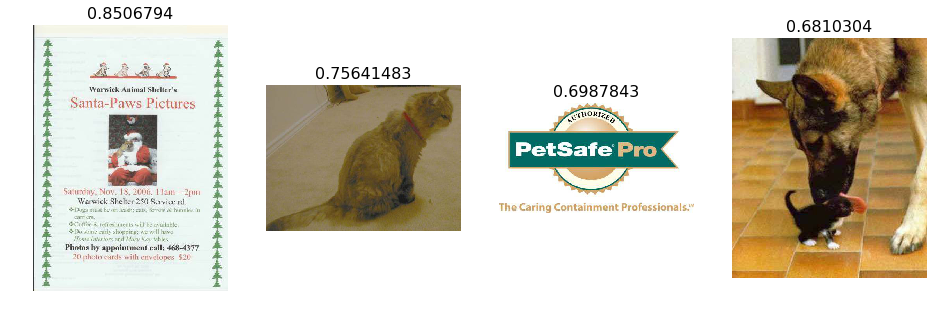

In [19]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


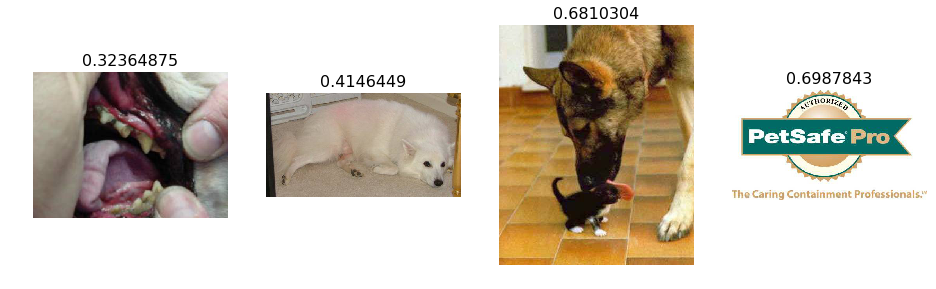

In [20]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [19]:
log_preds,y = learn.TTA(is_test=True)
probs = np.mean(np.exp(log_preds),0)

In [20]:
probs.shape

(12500, 2)

In [15]:
import numpy as np

In [50]:
isdog = probs[:,1]
print ("Raw Predictions: " + str(isdog[:5]))
print ("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print ("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [0.99928 0.00005 0.95704 0.99997 1.     ]
Mid Predictions: [0.57588 0.4683  0.42169 0.5134  0.45072 0.40996 0.42354 0.5284  0.53416 0.56185 0.50621 0.57203 0.47543
 0.46346 0.43702 0.42981 0.49854 0.40777 0.49435 0.54461 0.5658  0.51814 0.48965 0.53642 0.5614 ]
Edge Predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [51]:
isdog = isdog.clip(min=0.01, max=0.99)

In [52]:
print ("Raw Predictions: " + str(isdog[:5]))
print ("Mid Predictions: " + str(isdog[(isdog < .6) & (isdog > .4)]))
print ("Edge Predictions: " + str(isdog[(isdog == 1) | (isdog == 0)]))

Raw Predictions: [0.99    0.01    0.95704 0.99    0.99   ]
Mid Predictions: [0.57588 0.4683  0.42169 0.5134  0.45072 0.40996 0.42354 0.5284  0.53416 0.56185 0.50621 0.57203 0.47543
 0.46346 0.43702 0.42981 0.49854 0.40777 0.49435 0.54461 0.5658  0.51814 0.48965 0.53642 0.5614 ]
Edge Predictions: []


In [53]:
df = pd.DataFrame(isdog, columns=['label'])

In [54]:
df.insert(0,'id', [o[5:-4] for o in data.test_ds.fnames])

In [55]:
df.head()

,id,label
0,9885,0.990000
1,2701,0.010000
2,11231,0.957041
3,2964,0.990000
4,10651,0.990000


In [56]:
SUBM = f'{PATH}sub/'
os.makedirs(SUBM, exist_ok=True)
df.to_csv(f'{SUBM}subm.gz', compression='gzip', index=False)

In [57]:
FileLink(f'{SUBM}subm.gz')

/home/paperspace/fastai/courses/dl1/data/dogs-cats-redux/sub/subm.gz